# DSC 550 - Term Project: Final Project Submission
## Zicheng (Chance) Xu 

## Problem Statement: Predicting Wildfire Containment Time and Estimating Property Value Exposure for California Households

The state of California has been increasingly plagued by wildfires, which not only threaten lives and property but also pose significant economic challenges due to property damage and the time required for recovery. This project aims to address two key business problems pertinent to homeowners, insurance companies, real estate investors, and local governments:

1. **Prediction of Wildfire Recovery Time**: By examining historical wildfire data from [CAL FIRE](https://github.com/CornellCAC/python-data-science-notebooks/blob/main/data/wildfires/Fires_100.xlsx), specifically the duration from the alarm date to the containment date (CONT_DATE((containment date)) - ALARM_DATE), we aim to develop a model to forecast how long it might take to contain future wildfires. Factors like YEAR, AGENCY, CAUSE, and GIS_ACRES(number of acres burned as determined by analysis of GIS data) will serve as predictors. This model could be instrumental for residents in preparing for potential evacuations, for strategic resource allocation, and for planning recovery efforts.
    - **Response Variable**: Wildfire Containment Duration
    - **Predictor Variables**: Year of Incident, State, Agency, Unit ID(Indication of Geo Location), Month/Day of Incident, Cause, Impacted Areas, etc
3. **Estimation of Property Damage Costs**:Utilizing the [Zillow dataset](https://www.zillow.com/research/data/), which offers home value trends across various regions over time, alongside the wildfire data, we can assess the potential economic impact on properties due to wildfires. Although the Zillow data does not directly show changes in property values post-fire, it can help estimate the value of properties at risk in different regions at different points in time. This could be pivotal for insurance assessments, understanding investment risks, and for strategic decision-making by real estate investors.
   - **Response Variable**: Housing Value
   - **Predictor Variables**: Geo location variables, such as State, City, Metro, County, Zip; Size Rank, Record Date

**Business Relevance:**

- Homeowners: Could plan better for potential damages or evacuation scenarios.
- Insurance Companies: Might adjust risk assessment and pricing strategies based on potential exposure in fire-prone areas.
- Real Estate and Investors: Could make more informed investment decisions in areas prone to wildfires, considering the baseline property value. 
- Policy Makers: Could use this data to inform land use and emergency response policies.mpacted by California's wildfires.es.

## Load Initial Libraries

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

## Load and Clean the Data for Initial Analysis

### Wildfire Data

First, let's take look at the historical wildfire data from the Cornell Virtual Workshop. since the file has four tabs: 2017, 2016, 2015, and 2014, we will need to read them all and see if the data has the same fields and data types for each tab, and we can union them if they are.

In [9]:
# Define the sheets we want to read
sheets = ['2017','2016','2015','2014']

# Dictionary to hold DataFrames
dataframes = {}

for sheet_name in sheets:
    # Read the sheet into a DataFrame and store in the dictionary, idendyfying null values accordingly
    dataframes[sheet_name] = pd.read_excel('Fires_100.xlsx', sheet_name=sheet_name, na_values=['<Null>'])

In [10]:
# Check each of the DataFrame and see if we can concatenate them into one big DataFrame

# Function to analyze columns across DataFrames
def analyze_columns(dataframes):
    all_columns = set()
    column_sets = {}

    # Collect all unique columns
    for sheet_name, df in dataframes.items():
        column_sets[sheet_name] = set(df.columns)
        all_columns.update(column_sets[sheet_name])

    # Find overlapping (common) columns
    overlapping_columns = set.intersection(*column_sets.values())

    # Report overlapping columns
    print("Overlapping columns:", overlapping_columns)

    # Report columns unique to each DataFrame
    for sheet_name, columns in column_sets.items():
        unique_columns = columns - overlapping_columns
        if unique_columns:
            print(f"Columns unique to {sheet_name}:", unique_columns)

# Perform the analysis
analyze_columns(dataframes)

Overlapping columns: {'OBJECTIVE', 'AGENCY', 'CAUSE', 'COMMENTS'}
Columns unique to 2017: {'FIRE_NAME', 'GIS_ACRES', 'C_METHOD', 'STATE', 'INC_NUM', 'ALARM_DATE', 'YEAR_', 'UNIT_ID', 'CONT_DATE', 'REPORT_AC'}
Columns unique to 2016: {'FIRE_NAME', 'GIS_ACRES', 'C_METHOD', 'STATE', 'INC_NUM', 'ALARM_DATE', 'UNIT_ID', 'YEAR', 'CONT_DATE', 'REPORT_AC'}
Columns unique to 2015: {'FIRE_NUM', 'Shape_Length', 'FIRE_NAME', 'ALARM_DATE_Con', 'GIS_ACRES', 'C_METHOD', 'STATE', 'INC_NUM', 'Shape_Area', 'UNIT_ID', 'CONT_DATE_Conv', 'YEAR', 'REPORT_AC'}
Columns unique to 2014: {'REPORT ACRES', 'UNIT', 'GIS ACRES', 'YEAR', 'FIRE NAME'}


As we can see, the 2014 tab does not have date columns that I'm interested in for the analysis of the wildfire duration. Therefore, we can ignore it. For the other three tabs, the column names have slight difference for the fields that I'm intsrested. Let's clean up the names of the columns and concatenate these columns useful for our analysis: Year, State, Agency, Unit ID, Fire Name, Incident Number, Alarm Date, Containment Date, Cause, Objective, Reported Number of Acres Burned, Number of Acres burned as Determined by Analysis of GIS Data.

In [12]:
# Define the sheets we want to read (excluding 2014)
sheets = ['2017', '2016', '2015']

# Dictionary to hold DataFrames
dataframes = {}

for sheet_name in sheets:
    # Read the sheet into a DataFrame
    dataframes[sheet_name] = pd.read_excel('Fires_100.xlsx', sheet_name=sheet_name, na_values=['<Null>'])

# Define the common columns and their mappings for each DataFrame
common_columns = ['STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'CAUSE', 'OBJECTIVE', 'REPORT_AC', 'GIS_ACRES']
year_mapping = {'2017': 'YEAR_', '2016': 'YEAR', '2015': 'YEAR'}
alarm_date_mapping = {'2017': 'ALARM_DATE', '2016': 'ALARM_DATE', '2015': 'ALARM_DATE_Con'}
cont_date_mapping = {'2017': 'CONT_DATE', '2016': 'CONT_DATE', '2015': 'CONT_DATE_Conv'}

# Function to standardize column names before concatenation
def standardize_columns(df, sheet_name):
    df = df.rename(columns={
        year_mapping[sheet_name]: 'YEAR',
        alarm_date_mapping[sheet_name]: 'ALARM_DATE',
        cont_date_mapping[sheet_name]: 'CONT_DATE'
    })
    return df[common_columns + ['YEAR', 'ALARM_DATE', 'CONT_DATE']]

# Check data types and dimensions
def check_data_types_and_dimensions(dataframes):
    reference_df = standardize_columns(dataframes['2017'], '2017')
    common_columns_list = reference_df.columns.tolist()
    warnings = 0  # Counter for warnings
    
    for sheet_name, df in dataframes.items():
        standardized_df = standardize_columns(df, sheet_name)
        
        # Check dimensions
        print(f"Dimensions of DataFrame '{sheet_name}': {standardized_df.shape}")
        
        # Check data types
        for col in common_columns_list:
            if standardized_df[col].dtype != reference_df[col].dtype:
                print(f"Warning: Data type mismatch for column '{col}' in '{sheet_name}' - Expected {reference_df[col].dtype}, but got {standardized_df[col].dtype}")
                warnings += 1
    
    # If no warnings were printed, we assume all data types match
    if warnings == 0:
        print("All data types match across the specified columns.")

# Standardize and check before concatenation
check_data_types_and_dimensions(dataframes)

Dimensions of DataFrame '2017': (182, 12)
Dimensions of DataFrame '2016': (11795, 12)
Dimensions of DataFrame '2015': (11618, 12)


Now let's convert the columns to the proper data types.

In [14]:
# Function to update data types
def update_data_types(dataframes):
    reference_df = standardize_columns(dataframes['2017'], '2017')
    
    for sheet_name in ['2016', '2015']:
        df = standardize_columns(dataframes[sheet_name], sheet_name)
        
        # Update data types
        if df['INC_NUM'].dtype == 'object':
            df['INC_NUM'] = pd.to_numeric(df['INC_NUM'], errors='coerce').astype('Int64')  # 'Int64' for nullable integer
        
        if sheet_name == '2016':
            if df['YEAR'].dtype == 'object':
                df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce').astype('Int64')
        elif sheet_name == '2015':
            if df['YEAR'].dtype == 'float64':
                df['YEAR'] = df['YEAR'].astype('Int64')
        
        # Convert to datetime for 'ALARM_DATE' and 'CONT_DATE'
        for date_col in ['ALARM_DATE', 'CONT_DATE']:
            if df[date_col].dtype == 'object':
                df[date_col] = pd.to_datetime(df[date_col], format='%m/%d/%Y', errors='coerce')
        
        dataframes[sheet_name] = df

# Update data types
update_data_types(dataframes)

In [15]:
# Standardize and prepare each DataFrame for concatenation
standardized_dfs = []
for sheet_name, df in dataframes.items():
    standardized_dfs.append(standardize_columns(df, sheet_name))

# Concatenate the standardized DataFrames
merged_df = pd.concat(standardized_dfs, ignore_index=True)

print(f"Shape of the merged DataFrame: {merged_df.shape}")
print("Columns in merged DataFrame:", merged_df.columns.tolist())

Shape of the merged DataFrame: (23595, 12)
Columns in merged DataFrame: ['STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'CAUSE', 'OBJECTIVE', 'REPORT_AC', 'GIS_ACRES', 'YEAR', 'ALARM_DATE', 'CONT_DATE']


In [16]:
# Check the combined DataFrame
merged_df.head()

,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,CAUSE,OBJECTIVE,REPORT_AC,GIS_ACRES,YEAR,ALARM_DATE,CONT_DATE
0,California,California Department of Forestry and Fire Pro...,Tulare County,DINELY,286,2 - Equipment Use,Suppression (Wildfire),339.0,340.5638,2017.0,2017-06-07,2017-06-11
1,California,California Department of Forestry and Fire Pro...,Tulare County,ROADRUNNER,441,7 - Arson,Suppression (Wildfire),2289.0,2284.5960,2017.0,2017-07-30,2017-08-01
2,California,California Department of Forestry and Fire Pro...,Tulare County,ELEPHANT 2,420,7 - Arson,Suppression (Wildfire),416.0,415.2116,2017.0,2017-07-20,2017-07-22
3,California,California Department of Forestry and Fire Pro...,Tehama - Glenn CAL FIRE,TEHAMA,10345,10 - Vehicle,Suppression (Wildfire),194.0,194.0017,2017.0,2017-10-30,2017-10-31
4,California,California Department of Forestry and Fire Pro...,Tuolumne - Calaveras CAL FIRE,JACKSONVILLE,9024,14 - Unknown / Unidentified,Suppression (Wildfire),NaN,684.3565,2017.0,2017-07-29,2017-07-30


In [17]:
# Check the DataFrame information
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23595 entries, 0 to 23594
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   STATE       23595 non-null  object        
 1   AGENCY      23595 non-null  object        
 2   UNIT_ID     23589 non-null  object        
 3   FIRE_NAME   23539 non-null  object        
 4   INC_NUM     22600 non-null  Int64         
 5   CAUSE       23571 non-null  object        
 6   OBJECTIVE   23483 non-null  object        
 7   REPORT_AC   6982 non-null   float64       
 8   GIS_ACRES   23595 non-null  float64       
 9   YEAR        23527 non-null  Float64       
 10  ALARM_DATE  15703 non-null  datetime64[ns]
 11  CONT_DATE   6029 non-null   datetime64[ns]
dtypes: Float64(1), Int64(1), datetime64[ns](2), float64(2), object(6)
memory usage: 2.2+ MB


In [18]:
# Check if there's any duplication just in case
duplicated_rows = merged_df.duplicated().sum()

print(f"Number of duplicated rows: {duplicated_rows}")

Number of duplicated rows: 7354


Since there are 7354 duplications, let's remove them.

In [20]:
# Remove duplicated rows
merged_df_no_duplicates = merged_df.drop_duplicates().reset_index(drop=True)

# Check again for duplicates to confirm they've been removed
print(f"Number of duplicated rows after removal: {merged_df_no_duplicates.duplicated().sum()}")

Number of duplicated rows after removal: 0


In [21]:
merged_df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   STATE       16241 non-null  object        
 1   AGENCY      16241 non-null  object        
 2   UNIT_ID     16238 non-null  object        
 3   FIRE_NAME   16213 non-null  object        
 4   INC_NUM     15663 non-null  Int64         
 5   CAUSE       16222 non-null  object        
 6   OBJECTIVE   16183 non-null  object        
 7   REPORT_AC   4507 non-null   float64       
 8   GIS_ACRES   16241 non-null  float64       
 9   YEAR        16179 non-null  Float64       
 10  ALARM_DATE  11840 non-null  datetime64[ns]
 11  CONT_DATE   4041 non-null   datetime64[ns]
dtypes: Float64(1), Int64(1), datetime64[ns](2), float64(2), object(6)
memory usage: 1.5+ MB


Now, let's derive the new column that we need to for containment duration analysis and model building.

In [23]:
merged_df_no_duplicates['DURATION'] = (merged_df_no_duplicates['CONT_DATE'] - merged_df_no_duplicates['ALARM_DATE']).dt.days

merged_df_no_duplicates.head()

,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,CAUSE,OBJECTIVE,REPORT_AC,GIS_ACRES,YEAR,ALARM_DATE,CONT_DATE,DURATION
0,California,California Department of Forestry and Fire Pro...,Tulare County,DINELY,286,2 - Equipment Use,Suppression (Wildfire),339.0,340.5638,2017.0,2017-06-07,2017-06-11,4.0
1,California,California Department of Forestry and Fire Pro...,Tulare County,ROADRUNNER,441,7 - Arson,Suppression (Wildfire),2289.0,2284.5960,2017.0,2017-07-30,2017-08-01,2.0
2,California,California Department of Forestry and Fire Pro...,Tulare County,ELEPHANT 2,420,7 - Arson,Suppression (Wildfire),416.0,415.2116,2017.0,2017-07-20,2017-07-22,2.0
3,California,California Department of Forestry and Fire Pro...,Tehama - Glenn CAL FIRE,TEHAMA,10345,10 - Vehicle,Suppression (Wildfire),194.0,194.0017,2017.0,2017-10-30,2017-10-31,1.0
4,California,California Department of Forestry and Fire Pro...,Tuolumne - Calaveras CAL FIRE,JACKSONVILLE,9024,14 - Unknown / Unidentified,Suppression (Wildfire),NaN,684.3565,2017.0,2017-07-29,2017-07-30,1.0


In [24]:
# Check the Duration values range
print(merged_df_no_duplicates['DURATION'].min(), merged_df_no_duplicates['DURATION'].max())

-32862.0 3319.0


Since it does not make sense for a wildfire to last -32862 days or 3319 days, let's remove them. But before we remove them, let's check if there are other records with exceptionally large value, since it's easier for us to take care of the negative values.

In [26]:
merged_df_no_duplicates.sort_values(by='DURATION', ascending=False).head()

,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,CAUSE,OBJECTIVE,REPORT_AC,GIS_ACRES,YEAR,ALARM_DATE,CONT_DATE,DURATION
8715,California,National Park Service,Yosemite National Park,PIUTE,86,1 - Lightning,Suppression (Wildfire),552.470484,552.4727,1990.0,1990-08-13,1999-09-14,3319.0
10814,California,USDA Forest Service,Tahoe National Forest,RALSTON,1443,9 - Miscellaneous,Suppression (Wildfire),8422.000000,8421.0440,2007.0,2006-09-05,2007-09-17,377.0
12058,California,California Department of Forestry and Fire Pro...,Butte CDF,PANTHER,5648,9 - Miscellaneous,Suppression (Wildfire),6896.000000,6896.1980,2013.0,2013-05-01,2013-12-09,222.0
11544,California,California Department of Forestry and Fire Pro...,Butte CAL FIRE,PANTHER,5648,9 - Miscellaneous,Suppression (Wildfire),6896.000000,6896.1980,2013.0,2013-05-01,2013-12-09,222.0
11532,California,USDA Forest Service,Angeles National Forest,POWERHOUSE,2297,9 - Miscellaneous,Suppression (Wildfire),30268.000000,30267.6900,2013.0,2013-05-30,2013-12-18,202.0


Since there's only one extreme outlier, let's go ahead and remove it.

In [28]:
merged_df_no_duplicates = merged_df_no_duplicates[(merged_df_no_duplicates.DURATION >= 0) & 
    (merged_df_no_duplicates.DURATION != 3319)].reset_index(drop=True)

merged_df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   STATE       4022 non-null   object        
 1   AGENCY      4022 non-null   object        
 2   UNIT_ID     4019 non-null   object        
 3   FIRE_NAME   4018 non-null   object        
 4   INC_NUM     3800 non-null   Int64         
 5   CAUSE       4018 non-null   object        
 6   OBJECTIVE   3996 non-null   object        
 7   REPORT_AC   3824 non-null   float64       
 8   GIS_ACRES   4022 non-null   float64       
 9   YEAR        4022 non-null   Float64       
 10  ALARM_DATE  4022 non-null   datetime64[ns]
 11  CONT_DATE   4022 non-null   datetime64[ns]
 12  DURATION    4022 non-null   float64       
dtypes: Float64(1), Int64(1), datetime64[ns](2), float64(3), object(6)
memory usage: 416.5+ KB


### Zillow Housing Data

In [30]:
# Load the Zillow housing data
df_zillow = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

# Adjust pandas display options to show all columns
pd.set_option('display.max_columns', None)

df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,208873.462679,209054.745978,209539.156633,210517.561548,210552.558927,210399.788322,209645.446887,209677.950023,209449.272739,209821.317549,210678.335699,211833.721800,212543.523493,212251.205144,211546.046191,210790.007565,211463.021274,212716.566066,213886.195937,214468.033240,214379.848005,214398.470678,214087.831027,213349.155008,212711.369626,212268.325166,212672.350756,213243.294477,214171.477022,214991.626054,215168.671858,214850.569896,213873.603185,213218.517150,212491.008375,212822.195135,213773.833942,215041.836323,21

In [31]:
# let's check the first 9 columns which are not the time series
df_zillow_first9 = df_zillow.iloc[:, :9]

# Display basic information about the first 9 columns
print("Basic Information of the First 9 Columns:")
df_zillow_first9.info()

# Display data types of each column in the first 9
print("\nData Types of Each Column in the First 9:")
print(df_zillow_first9.dtypes)

# Get basic statistics for numerical columns in the first 9
print("\nBasic Statistics for Numerical Columns in the First 9:")
print(df_zillow_first9.describe())

# Check for missing values in the first 9 columns
print("\nMissing Values in Each of the First 9 Columns:")
print(df_zillow_first9.isnull().sum())

Basic Information of the First 9 Columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26331 entries, 0 to 26330
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RegionID    26331 non-null  int64 
 1   SizeRank    26331 non-null  int64 
 2   RegionName  26331 non-null  int64 
 3   RegionType  26331 non-null  object
 4   StateName   26331 non-null  object
 5   State       26331 non-null  object
 6   City        25287 non-null  object
 7   Metro       21592 non-null  object
 8   CountyName  26331 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.8+ MB

Data Types of Each Column in the First 9:
RegionID       int64
SizeRank       int64
RegionName     int64
RegionType    object
StateName     object
State         object
City          object
Metro         object
CountyName    object
dtype: object

Basic Statistics for Numerical Columns in the First 9:
            RegionID      SizeRank    RegionName
count   2

Now let's pivot the DataFrame for easier analysis and model building.

In [33]:
# Define the columns to keep as is (first 9 columns)
id_vars = df_zillow_first9.columns.tolist()

# Use melt to pivot the DataFrame
df_zillow_pivoted = pd.melt(df_zillow, 
                            id_vars=id_vars, 
                            var_name='RecordDate', 
                            value_name='HousingValue')

# Convert 'RecordDate' to datetime for easier handling
df_zillow_pivoted['RecordDate'] = pd.to_datetime(df_zillow_pivoted['RecordDate'])

# Display the first few rows to verify the transformation
df_zillow_pivoted.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,RecordDate,HousingValue
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2000-01-31,208873.462679
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,2000-01-31,129593.365790
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,103665.724381
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,147260.760117
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,102393.669560


In [34]:
# Check for duplication
df_zillow_pivoted.duplicated().sum()

0

## Data Visualizations

### 1. Average Duration by Unit Place

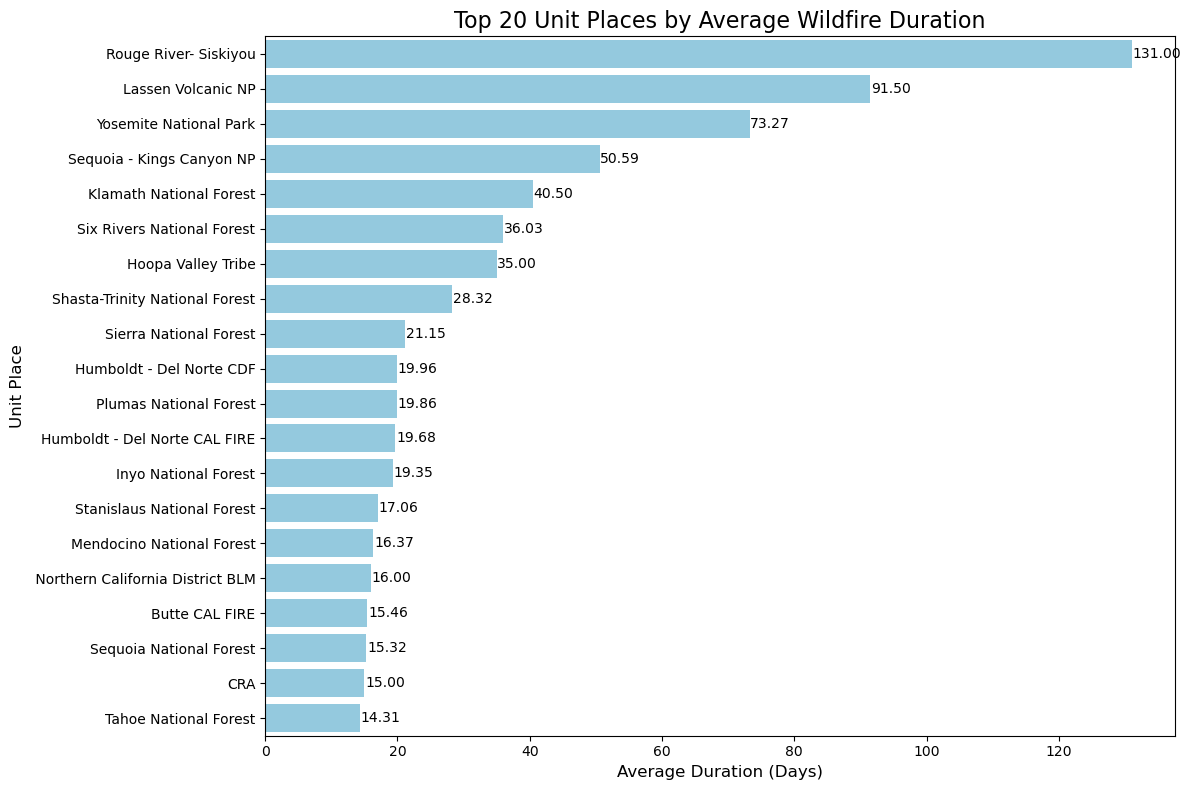

In [37]:
import matplotlib.pyplot as plt

# Calculate average duration by UNIT_ID, sort, and select top 20
avg_duration_by_unit = merged_df_no_duplicates.groupby('UNIT_ID')['DURATION'].mean().sort_values(ascending=False).head(20)

# Set up the plot
plt.figure(figsize=(12, 8))

# Create a horizontal bar plot
sns.barplot(x=avg_duration_by_unit.values, y=avg_duration_by_unit.index, 
            color='skyblue', 
            order=avg_duration_by_unit.index)  # Order by the sorted values

plt.title('Top 20 Unit Places by Average Wildfire Duration', fontsize=16)
plt.xlabel('Average Duration (Days)', fontsize=12)
plt.ylabel('Unit Place', fontsize=12)

# Add value labels to each bar
for i, v in enumerate(avg_duration_by_unit.values):
    plt.text(v + 0.1, i, f'{v:.2f}', va='center')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

As we can see Rogue River - Siskiyou National Forest had an average of 131 days for the duration of the wildfire, which is more than double the duration of the average Sequoia & Kings Canyon National Parks wildfire who's at the fourth place in the ranking. Los Angeles unit is not on the top 20 longest duration list. According to [NBC News](https://www.nbcnews.com/news/us-news/california-wildfires-what-we-know-palisades-eaton-los-angeles-rcna188239), the fire was ~51% contained on the Saturday of the same week the fire happened for the Palisades Fire, and 81% contained for the Eaton Fire.

### 2. Average Duration by CAUSE

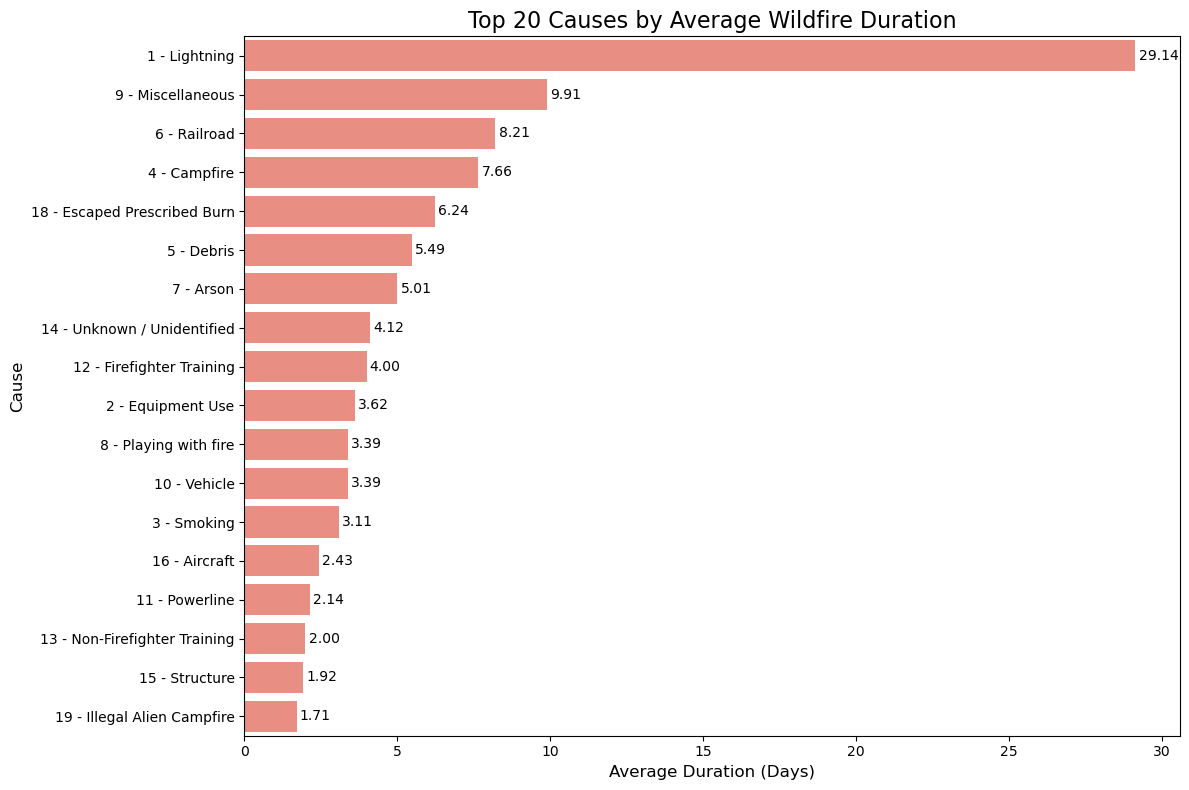

In [40]:
# Calculate average duration by CAUSE, sort, and select top 20
avg_duration_by_cause = merged_df_no_duplicates.groupby('CAUSE')['DURATION'].mean().sort_values(ascending=False).head(20)

# Set up the plot
plt.figure(figsize=(12, 8))

# Create a horizontal bar plot
sns.barplot(x=avg_duration_by_cause.values, y=avg_duration_by_cause.index, 
            color='salmon',  
            order=avg_duration_by_cause.index)  # Order by the sorted values

plt.title('Top 20 Causes by Average Wildfire Duration', fontsize=16)
plt.xlabel('Average Duration (Days)', fontsize=12)
plt.ylabel('Cause', fontsize=12)

# Add value labels to each bar
for i, v in enumerate(avg_duration_by_cause.values):
    plt.text(v + 0.1, i, f'{v:.2f}', va='center')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

Based on this initial visualization, wildfire has longer duration on average when the cause is lightning. We need to do some further analysis to confirm if this is the case, as it could just be that location of the wildfire was more prone to the spread of the fire, but not by the cause.

### 3. Relationship between Number of Acres Burned as Determined by Analysis of GIS data and Duration

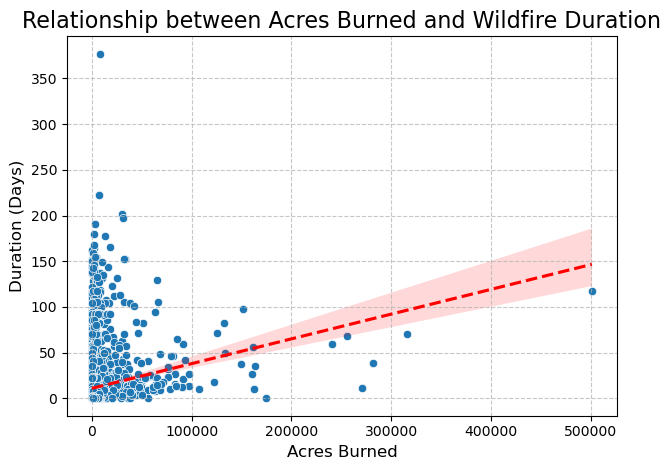

In [43]:
# Create a scatter plot
sns.scatterplot(x='GIS_ACRES', y='DURATION', data=merged_df_no_duplicates)

plt.title('Relationship between Acres Burned and Wildfire Duration', fontsize=16)

# Add a trend line to see the general direction of the relationship
sns.regplot(x='GIS_ACRES', y='DURATION', data=merged_df_no_duplicates, scatter=False, color='red', line_kws={'linestyle':'--'})

plt.xlabel('Acres Burned', fontsize=12)
plt.ylabel('Duration (Days)', fontsize=12)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

As the scatterplot shows, there's a very light correlation between the acres burned and the duration of the wildfire.

### 4. Los Angeles Housing Trend

Since the most impacted area of the recent wildfire is in the Los Angeles area, let's take a look at the housing trend in this area over the years.

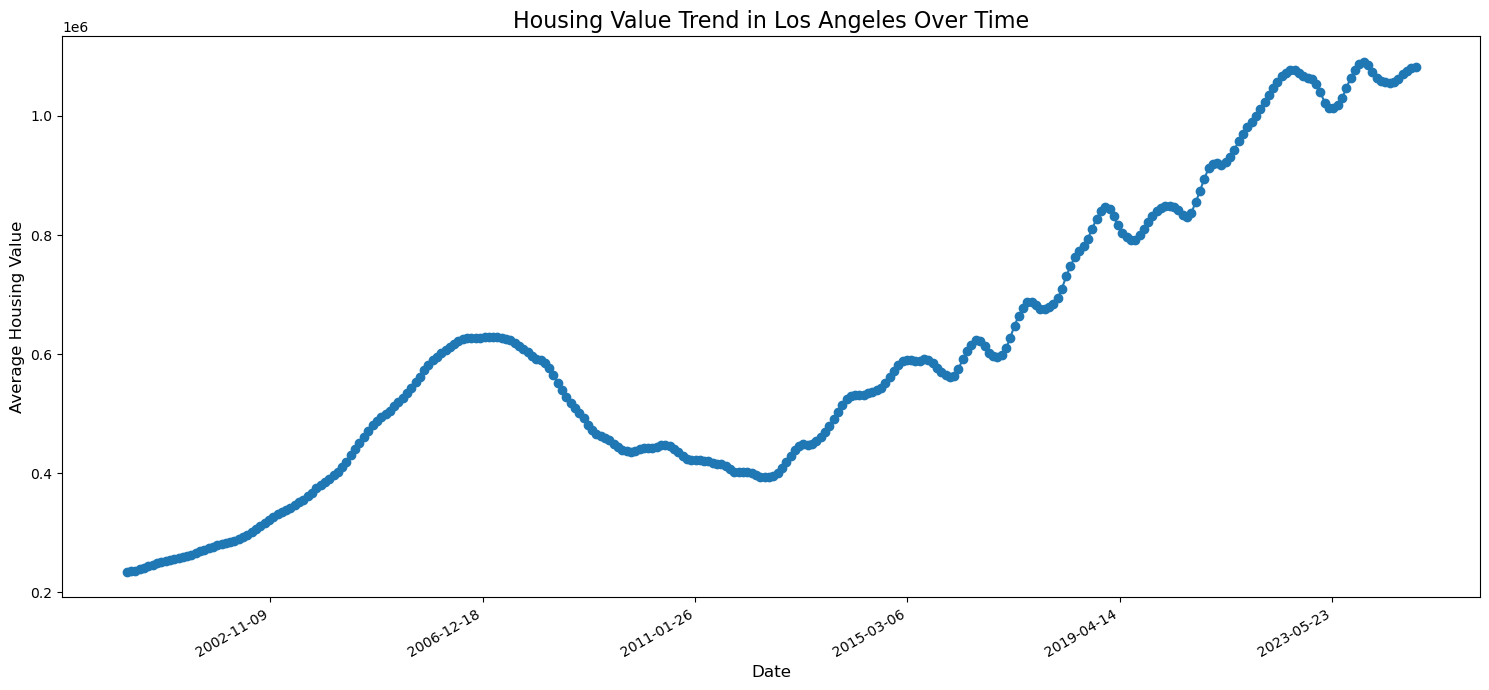

In [47]:
# Filter for Los Angeles and aggregate HousingValue by date
la_housing = df_zillow_pivoted[df_zillow_pivoted['City'] == 'Los Angeles'].groupby('RecordDate')['HousingValue'].mean().reset_index()

# Set up the plot
plt.figure(figsize=(15, 7))

# Draw the line plot
plt.plot(la_housing['RecordDate'], la_housing['HousingValue'], marker='o')

# Customize the plot
plt.title('Housing Value Trend in Los Angeles Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Housing Value', fontsize=12)

# Format x-axis for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit number of ticks to make the chart less cluttered
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Show the plot
plt.tight_layout()
plt.show()

Clearly, the housing value kept upward trend after the dip around early 2007 until around 2012, the period within which there was economic crysis. Recently it's averaging around somewhere a little over 1 million dollars. For the Los Angeles households impacted by the wildfire, they probably are looking at a total cost close to 1 million dollars on average to rebuild a house, before insurance coverage, and if we assume the rebuilding cost is similar to the existing housing market cost.

## Model Building

Now that we have cleaned our data in phase 1 and conducted initial visualization analysis and statistics analysis, we are going to move on to the next phase of data cleaning to make the data ready for model building and build the model. Let's start with the wildfire dataset.

### Wildfire Data

In [52]:
# Make a copy of the wildfire DataFrame from Phase 1
df_wf = merged_df_no_duplicates.copy()

In [53]:
# Check the head of the DataFrame
df_wf.head()

,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,CAUSE,OBJECTIVE,REPORT_AC,GIS_ACRES,YEAR,ALARM_DATE,CONT_DATE,DURATION
0,California,California Department of Forestry and Fire Pro...,Tulare County,DINELY,286,2 - Equipment Use,Suppression (Wildfire),339.0,340.5638,2017.0,2017-06-07,2017-06-11,4.0
1,California,California Department of Forestry and Fire Pro...,Tulare County,ROADRUNNER,441,7 - Arson,Suppression (Wildfire),2289.0,2284.5960,2017.0,2017-07-30,2017-08-01,2.0
2,California,California Department of Forestry and Fire Pro...,Tulare County,ELEPHANT 2,420,7 - Arson,Suppression (Wildfire),416.0,415.2116,2017.0,2017-07-20,2017-07-22,2.0
3,California,California Department of Forestry and Fire Pro...,Tehama - Glenn CAL FIRE,TEHAMA,10345,10 - Vehicle,Suppression (Wildfire),194.0,194.0017,2017.0,2017-10-30,2017-10-31,1.0
4,California,California Department of Forestry and Fire Pro...,Tuolumne - Calaveras CAL FIRE,JACKSONVILLE,9024,14 - Unknown / Unidentified,Suppression (Wildfire),NaN,684.3565,2017.0,2017-07-29,2017-07-30,1.0


First, let's take a look at the State column.

In [55]:
df_wf.STATE.value_counts()

STATE
California    4011
Nevada           8
Oregon           2
Arizona          1
Name: count, dtype: int64

Since the column is very inbalanced and predominantly contains California as value. Let's remove it as it's not useful for us. Also, for the same reason, let's remove rows when the STATE is not California, as there is too few records for the areas outside the California state.

Another field we can safely remove is the Fire name, as it does not provide much information on the fire severity or duration itself.

In addition, we can safely remove the Incident Number field as it's simply an ID number.

Also, let's get rid of REPORT_AC as the GIS_ACRES represents more accurate impact area data, and remove CONT_DATE field as we have derived the duration field, and the CONT_DATE field will cause data leakage if we keep it with the ALARM_DATE field which we want to use in the predictor variables.

Last but not least, since the [github repo](https://github.com/abarbour/FireHistory/tree/master/data) indicates the OBJECTIVE field only has two possible values and the second value - Resource Benefit (WFU) is not useful for our case, we can remove the variable as well.

In [57]:
# Display the old shape
print(f"Old shape of df_wf: {df_wf.shape}")

# Filter to keep only California rows
df_wf = df_wf[df_wf['STATE'] == 'California']

# Remove specified columns
columns_to_drop = ['STATE', 'FIRE_NAME', 'INC_NUM', 'OBJECTIVE', 'REPORT_AC', 'CONT_DATE']
df_wf = df_wf.drop(columns=columns_to_drop)

# Display the new shape
print(f"New shape of df_wf: {df_wf.shape}")

Old shape of df_wf: (4022, 13)
New shape of df_wf: (4011, 7)


Next, let's get rid of the numericals and the dash in front of the values in CAUSE field.

In [59]:
print(f"CAUSE Before Transformation: {df_wf.CAUSE.unique()}")

# Replace the pattern at the start of the string with an empty string
df_wf['CAUSE'] = df_wf['CAUSE'].str.replace(r'^\d+\s*-\s*', '', regex=True)

print(f"CAUSE After Transformation: {df_wf.CAUSE.unique()}")

CAUSE Before Transformation: ['2 - Equipment Use' '7 - Arson' '10 - Vehicle'
 '14 - Unknown / Unidentified' '11 - Powerline' '9 - Miscellaneous'
 '1 - Lightning' '5 - Debris' '4 - Campfire' '3 - Smoking'
 '15 - Structure' '8 - Playing with fire' '16 - Aircraft' '6 - Railroad'
 '18 - Escaped Prescribed Burn' nan '12 - Firefighter Training'
 '13 - Non-Firefighter Training' '19 - Illegal Alien Campfire']
CAUSE After Transformation: ['Equipment Use' 'Arson' 'Vehicle' 'Unknown / Unidentified' 'Powerline'
 'Miscellaneous' 'Lightning' 'Debris' 'Campfire' 'Smoking' 'Structure'
 'Playing with fire' 'Aircraft' 'Railroad' 'Escaped Prescribed Burn' nan
 'Firefighter Training' 'Non-Firefighter Training'
 'Illegal Alien Campfire']


Next, let's extract features from the ALARM_DATE field.

In [61]:
df_wf['ALARM_MONTH'] = df_wf['ALARM_DATE'].dt.month
df_wf['ALARM_DAY_OF_YEAR'] = df_wf['ALARM_DATE'].dt.dayofyear

# Drop the ALARM_DATE field
df_wf = df_wf.drop('ALARM_DATE', axis=1)

# Check the head
df_wf.head()

,AGENCY,UNIT_ID,CAUSE,GIS_ACRES,YEAR,DURATION,ALARM_MONTH,ALARM_DAY_OF_YEAR
0,California Department of Forestry and Fire Pro...,Tulare County,Equipment Use,340.5638,2017.0,4.0,6,158
1,California Department of Forestry and Fire Pro...,Tulare County,Arson,2284.5960,2017.0,2.0,7,211
2,California Department of Forestry and Fire Pro...,Tulare County,Arson,415.2116,2017.0,2.0,7,201
3,California Department of Forestry and Fire Pro...,Tehama - Glenn CAL FIRE,Vehicle,194.0017,2017.0,1.0,10,303
4,California Department of Forestry and Fire Pro...,Tuolumne - Calaveras CAL FIRE,Unknown / Unidentified,684.3565,2017.0,1.0,7,210


In [62]:
# Reset the index of df_wf
df_wf = df_wf.reset_index(drop=True)

# Check the info of df_wf
df_wf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011 entries, 0 to 4010
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGENCY             4011 non-null   object 
 1   UNIT_ID            4010 non-null   object 
 2   CAUSE              4007 non-null   object 
 3   GIS_ACRES          4011 non-null   float64
 4   YEAR               4011 non-null   Float64
 5   DURATION           4011 non-null   float64
 6   ALARM_MONTH        4011 non-null   int32  
 7   ALARM_DAY_OF_YEAR  4011 non-null   int32  
dtypes: Float64(1), float64(2), int32(2), object(3)
memory usage: 223.4+ KB


As we can see, UNIT_ID and CAUSE has only a few null values, and we can safely remove them.

In [64]:
# Remove rows with any null values
df_wf = df_wf.dropna()

# Reset the index of df_wf
df_wf = df_wf.reset_index(drop=True)

# Check the DataFrame info after removing nulls
df_wf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4006 entries, 0 to 4005
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGENCY             4006 non-null   object 
 1   UNIT_ID            4006 non-null   object 
 2   CAUSE              4006 non-null   object 
 3   GIS_ACRES          4006 non-null   float64
 4   YEAR               4006 non-null   Float64
 5   DURATION           4006 non-null   float64
 6   ALARM_MONTH        4006 non-null   int32  
 7   ALARM_DAY_OF_YEAR  4006 non-null   int32  
dtypes: Float64(1), float64(2), int32(2), object(3)
memory usage: 223.1+ KB


In [65]:
df_wf.head()

,AGENCY,UNIT_ID,CAUSE,GIS_ACRES,YEAR,DURATION,ALARM_MONTH,ALARM_DAY_OF_YEAR
0,California Department of Forestry and Fire Pro...,Tulare County,Equipment Use,340.5638,2017.0,4.0,6,158
1,California Department of Forestry and Fire Pro...,Tulare County,Arson,2284.5960,2017.0,2.0,7,211
2,California Department of Forestry and Fire Pro...,Tulare County,Arson,415.2116,2017.0,2.0,7,201
3,California Department of Forestry and Fire Pro...,Tehama - Glenn CAL FIRE,Vehicle,194.0017,2017.0,1.0,10,303
4,California Department of Forestry and Fire Pro...,Tuolumne - Calaveras CAL FIRE,Unknown / Unidentified,684.3565,2017.0,1.0,7,210


Next let's separate the predictor variables and the target variable.

In [67]:
X_wf = df_wf.drop('DURATION', axis=1)
y_wf = df_wf['DURATION']

Next let's split the data into train and test sets.

In [69]:
from sklearn.model_selection import train_test_split

X_wf_train, X_wf_test, y_wf_train, y_wf_test = train_test_split(X_wf, y_wf, test_size=0.25, random_state=42)

Next, let's hot encode the categorical variables.

In [71]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from collections import Counter

# Combine categories from both train and test sets for each feature
categorical_features = ['AGENCY', 'UNIT_ID', 'CAUSE']

for feature in categorical_features:
    # Count categories in both datasets together to determine rare categories
    all_categories = pd.concat([X_wf_train[feature], X_wf_test[feature]], ignore_index=True)
    category_counts = Counter(all_categories)
    
    # Define rare categories as those appearing less than 2 times
    rare_categories = {k for k, v in category_counts.items() if v < 2}
    
    # Map rare categories to 'Other' in both train and test sets
    X_wf_train[feature] = X_wf_train[feature].replace(list(rare_categories), 'Other')
    X_wf_test[feature] = X_wf_test[feature].replace(list(rare_categories), 'Other')

# Now proceed with OneHotEncoding, using 'ignore' for unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features without transformation
)

X_wf_train_processed = preprocessor.fit_transform(X_wf_train)
X_wf_test_processed = preprocessor.transform(X_wf_test)

# Get the names of the new features after one-hot encoding
one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
numerical_features = [col for col in X_wf.columns if col not in categorical_features]

# Combine one-hot encoded names with numerical features
feature_names = list(one_hot_feature_names) + numerical_features

In [72]:
# Check the new feature names length
len(feature_names)

118

Next, let's move on to feature selection, dimension reduction for model building preparation.

Selected features: ['AGENCY_California Department of Forestry and Fire Protection', 'AGENCY_National Park Service', 'AGENCY_USDA Forest Service', 'UNIT_ID_Sequoia - Kings Canyon NP', 'CAUSE_Lightning', 'CAUSE_Non-Firefighter Training', 'GIS_ACRES', 'YEAR', 'ALARM_MONTH', 'ALARM_DAY_OF_YEAR']


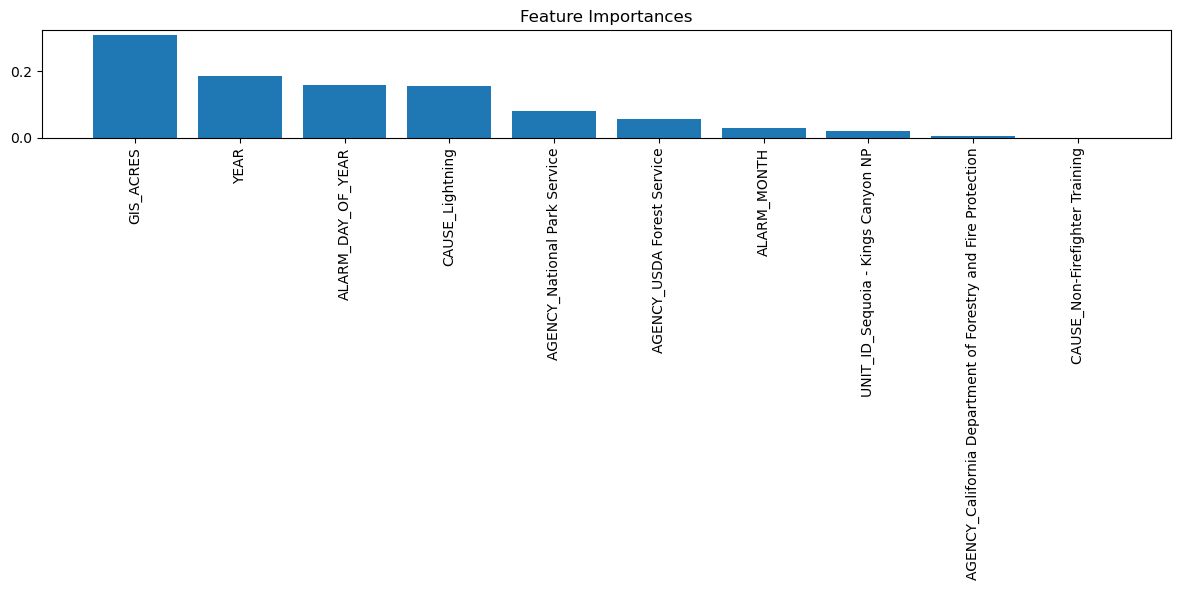

In [74]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# Feature Selection using Mutual Information for regression
selector = SelectKBest(score_func=mutual_info_regression, k=10)  # Select top 10 features
X_wf_train_selected = selector.fit_transform(X_wf_train_processed, y_wf_train)
X_wf_test_selected = selector.transform(X_wf_test_processed)

# Print selected feature names
selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

# Feature Importance with Random Forest (for visualization)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_wf_train_selected, y_wf_train)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(selected_features)), importances[indices])
plt.xticks(range(len(selected_features)), [selected_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [75]:
# Dimension Reduction with PCA
# Here, we'll use PCA to see if we can reduce dimensions while keeping 95% of variance
pca = PCA(n_components=0.95)
X_wf_train_pca = pca.fit_transform(X_wf_train_selected)
X_wf_test_pca = pca.transform(X_wf_test_selected)

print("Number of PCA components:", pca.n_components_)

Number of PCA components: 1


PCA has reduced our data to just one principal component while retaining 95% of the variance, it suggests that most of the variability in your selected features can be explained by a single linear combination of those features. This could mean:
- The features we've selected are highly correlated with each other, or one feature dominates the others in terms of explaining variance.
- There's a strong underlying trend or pattern in our data that can be captured by this one component.

To find a good model, we can use iterative approach and model selections.

That being said, let's build a workflow to compare using all 10 selected features versus different numbers of PCA components, while also testing with at least two different regression models (Random Forest and Linear Regression). We'll use R-squared score and Mean Squared Error (MSE) for evaluation.

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Models to compare
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

# PCA components to test
pca_components = [1, 2, 3, 4, 5]  # Testing different numbers of components

results = {}

# Test with all 10 selected features
for model_name, model in models.items():
    model.fit(X_wf_train_selected, y_wf_train)
    predictions = model.predict(X_wf_test_selected)
    r2 = r2_score(y_wf_test, predictions)
    mse = mean_squared_error(y_wf_test, predictions)
    results[(model_name, 'All Features')] = {'R2': r2, 'MSE': mse}

# Test with different PCA components
for comp in pca_components:
    pca = PCA(n_components=comp)
    X_wf_train_pca = pca.fit_transform(X_wf_train_selected)
    X_wf_test_pca = pca.transform(X_wf_test_selected)
    
    for model_name, model in models.items():
        model.fit(X_wf_train_pca, y_wf_train)
        predictions = model.predict(X_wf_test_pca)
        r2 = r2_score(y_wf_test, predictions)
        mse = mean_squared_error(y_wf_test, predictions)
        results[(model_name, f'PCA {comp} Components')] = {'R2': r2, 'MSE': mse}

# Display results
for key, metrics in results.items():
    print(f"{key}: R2 = {metrics['R2']:.4f}, MSE = {metrics['MSE']:.4f}")

# Find the best combo based on highest R-squared and lowest MSE
best_combo_r2 = max(results, key=lambda x: results[x]['R2'])
best_combo_mse = min(results, key=lambda x: results[x]['MSE'])

print("\nBest combo by R-squared:", best_combo_r2)
print("Best combo by MSE:", best_combo_mse)

# Since we've already calculated performance on the test set, we just display the results
print(f"\nFinal evaluation for {best_combo_r2}:")
print(f"R2 Score: {results[best_combo_r2]['R2']:.4f}")
print(f"Mean Squared Error: {results[best_combo_r2]['MSE']:.4f}")

('Random Forest', 'All Features'): R2 = 0.5989, MSE = 334.3008
('Linear Regression', 'All Features'): R2 = 0.3601, MSE = 533.3817
('Random Forest', 'PCA 1 Components'): R2 = -0.1529, MSE = 960.9076
('Linear Regression', 'PCA 1 Components'): R2 = 0.0184, MSE = 818.1206
('Random Forest', 'PCA 2 Components'): R2 = 0.1075, MSE = 743.9227
('Linear Regression', 'PCA 2 Components'): R2 = 0.0178, MSE = 818.6291
('Random Forest', 'PCA 3 Components'): R2 = 0.1983, MSE = 668.2106
('Linear Regression', 'PCA 3 Components'): R2 = 0.0245, MSE = 813.0446
('Random Forest', 'PCA 4 Components'): R2 = 0.4139, MSE = 488.5374
('Linear Regression', 'PCA 4 Components'): R2 = 0.1266, MSE = 727.9464
('Random Forest', 'PCA 5 Components'): R2 = 0.5848, MSE = 346.0893
('Linear Regression', 'PCA 5 Components'): R2 = 0.2444, MSE = 629.7589

Best combo by R-squared: ('Random Forest', 'All Features')
Best combo by MSE: ('Random Forest', 'All Features')

Final evaluation for ('Random Forest', 'All Features'):
R2 Score:

**Model Results Summary**

Performance Summary:
- Best Performing Model:
The 'Random Forest' model using all 10 selected features ('All Features') stands out as the best performer by both metrics:
Highest R-squared: 0.5989
Lowest Mean Squared Error (MSE): 334.3008
- Random Forest with PCA: 
Performance decreases as the number of PCA components reduces from 5 to 1. 
Even with 5 PCA components, there's a noticeable drop in performance compared to using all features (R2 of 0.2444 vs. 0.5989).
With 1 PCA component, there's a significant negative R-squared (-0.1529), indicating the model performs worse than a horizontal line (mean prediction) on the test set.
- Linear Regression:
Performs consistently worse than Random Forest across all configurations.
The highest R-squared for Linear Regression is 0.3601 with all features, which is still notably lower than Random Forest's performance.
Like Random Forest, its performance also degrades with fewer PCA components, though the decline is less drastic. It barely reaches positive R-squared with 1 component (0.0184).

Key Observations:
- Feature Importance: Using all features seems to capture the variance in the target variable better than any PCA reduction, particularly for Random Forest. This suggests that the original features, despite being selected down to 10, still carry important, possibly non-linear interactions that PCA does not preserve well.
- Model Complexity: Random Forest, capable of capturing non-linear relationships, benefits more from the full set of selected features. Linear Regression, being a simpler model, shows some improvement with more PCA components but doesn't match Random Forest's performance.
- Dimensionality Reduction: PCA does not appear to be beneficial in this case. The reduction in the number of features leads to a loss of predictive power, indicating that the relationship between features and the target might be complex or that PCA simplifies the data in a way that loses critical information for prediction.
- Model Selection: For this dataset and task, a Random Forest model without further dimensionality reduction (using all selected features) is recommended based on these results.

These findings suggest that for predicting fire duration in this dataset, maintaining the original structure of the selected features is more advantageous than reducing dimensions with PCA, at least with the models and methods tested. Further exploration might include trying other models that could benefit from dimensionality reduction or different feature engineering techniques.

### Containment Duration Prediction

Since we have the best candidate of the models and the features/PCA components that we trained on, let's use the best performing candidates to make predictions on the 2025 California Wildfire that we are interested in.

According to the [Cal Fire](https://www.fire.ca.gov/incidents/2025) we have the list of the wildfires in California that started early this year and have been contained. We can randomly pick a few of them and use related predictor variables, feed to our best performing model and see how the prediction goes.

In [17]:
# Create the DataFrame for the 2025 California Wildfire, sampled from Cal Fire (data found from the linked site above) for prediction
wf2025 = {
    'AGENCY': ['Local Response Area', 'Local Response Area', 'Local Response Area'],
    'UNIT_ID': ['Los Angeles County', 'Los Angeles County', 'Los Angeles County'],
    'CAUSE': ['Unknown / Unidentified', 'Unknown / Unidentified', 'Unknown / Unidentified'],
    'GIS_ACRES': [23707.0000, 1052.0000, 799.0000],
    'YEAR': [2025.0, 2025.0, 2025.0],
    'DURATION': [44.0, 3.00, 8.00],
    'ALARM_MONTH': [1, 1, 1],
    'ALARM_DAY_OF_YEAR': [7, 9, 7]
}

df_2025wf = pd.DataFrame(wf2025)

In [21]:
df_2025wf

,AGENCY,UNIT_ID,CAUSE,GIS_ACRES,YEAR,DURATION,ALARM_MONTH,ALARM_DAY_OF_YEAR
0,Local Response Area,Los Angeles County,Unknown / Unidentified,23707.0,2025.0,44.0,1,7
1,Local Response Area,Los Angeles County,Unknown / Unidentified,1052.0,2025.0,3.0,1,9
2,Local Response Area,Los Angeles County,Unknown / Unidentified,799.0,2025.0,8.0,1,7


In [124]:
# Preprocess the 2025 data
X_2025wf = df_2025wf.drop('DURATION', axis=1)  # Drop DURATION for prediction

# Transform 2025 data with the same preprocessor and selector from the processing during the model building for the wildfire data
X_2025wf_processed = preprocessor.transform(X_2025wf)
X_2025wf_selected = selector.transform(X_2025wf_processed)

In [126]:
# Train the Random Forest model with the best configuration
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_wf_train_selected, y_wf_train)

# Predict DURATION for 2025 data
predictions_2025 = rf_model.predict(X_2025wf_selected)

# Add predictions to the 2025 DataFrame
df_2025wf['Predicted_DURATION'] = predictions_2025

In [132]:
# Compare predictions with actual durations
r2_2025 = r2_score(df_2025wf['DURATION'], predictions_2025)
mse_2025 = mean_squared_error(df_2025wf['DURATION'], predictions_2025)
rmse_2025 = np.sqrt(mse_2025)

print("2025 Wildfire Data Predictions:")
print(df_2025wf[['AGENCY', 'UNIT_ID', 'CAUSE', 'GIS_ACRES', 'YEAR', 'ALARM_MONTH', 'ALARM_DAY_OF_YEAR', 'DURATION', 'Predicted_DURATION']])
print(f"\nPerformance on 2025 Data:")
print(f"R2 Score: {r2_2025:.4f}")
print(f"Mean Squared Error: {mse_2025:.4f}")
print(f"Root Mean Squared Error: {rmse_2025:.4f} days")

2025 Wildfire Data Predictions:
                AGENCY             UNIT_ID                   CAUSE  GIS_ACRES  \
0  Local Response Area  Los Angeles County  Unknown / Unidentified    23707.0   
1  Local Response Area  Los Angeles County  Unknown / Unidentified     1052.0   
2  Local Response Area  Los Angeles County  Unknown / Unidentified      799.0   

     YEAR  ALARM_MONTH  ALARM_DAY_OF_YEAR  DURATION  Predicted_DURATION  
0  2025.0            1                  7      44.0               86.41  
1  2025.0            1                  9       3.0                3.52  
2  2025.0            1                  7       8.0                3.28  

Performance on 2025 Data:
R2 Score: -0.8199
Mean Squared Error: 607.0523
Root Mean Squared Error: 24.6384 days


Given the prediction results and the training/tesing results, we can draw the following summary:

**Interpretation:**
- Accuracy: The model’s predictions on the 2025 data show mixed results. For smaller fires (GIS_ACRES = 1,052 and 799), the predictions (3.52 and 3.28 days) are relatively close to the actual durations (3.0 and 8.0 days), with errors of 0.52 and -4.72 days, respectively. However, for the large fire (GIS_ACRES = 23,707), the prediction (86.41 days) significantly overestimates the actual duration (44.0 days), with an error of 42.41 days.

- Overall Fit: The negative R2 score (-0.8199) indicates that the model performs worse than a simple mean prediction on this small 2025 dataset, suggesting poor generalization. The RMSE of 24.64 days is higher than the training RMSE (18.28 days), reinforcing that the model struggles with this new data.

- Error Magnitude: The RMSE of 24.64 days means predictions are, on average, off by about 25 days, which is significant given the actual durations range from 3 to 44 days in this sample.

**Key Observations**
- Training vs. Prediction Performance: The model performed better on the test set from the original data (R2 = 0.5989, RMSE ≈ 18.28 days) than on the 2025 data (R2 = -0.8199, RMSE = 24.64 days). This discrepancy suggests potential issues with data drift (e.g., different fire characteristics in 2025) or overfitting to the training data.

- Large Fire Prediction: The significant overestimation for the largest fire (23,707 acres) may indicate that the model overemphasizes factors like GIS_ACRES without adequately capturing other contextual variables (e.g., firefighting resources or weather conditions) that might have led to faster containment in 2025.

- Small Sample Size: With only three data points in the 2025 dataset, performance metrics like R2 are highly sensitive to individual errors, particularly the large error for Fire 1. This small sample limits robust conclusions about generalization.

**Future Action Items:**
- Further Investigation: Examine why the model overpredicts for large fires. Additional features (e.g., weather, crew size) or updated training data including more recent wildfires might improve accuracy.

- Model Refinement: Consider retraining with a broader dataset or using cross-validation to better assess generalization. Ensemble methods or hyperparameter tuning could also enhance performance.

- Practical Use: For now, the model provides decent estimates for smaller fires but should be used cautiously for large fires until refined.

In summary, while the Random Forest model with 10 features was effective on historical data, its performance on the 2025 data highlights limitations, particularly for larger wildfires, necessitating further refinement for reliable real-world application.

### Zillow Housing Data

In [137]:
# Make a copy of the Zillow DataFrame
df_zl = df_zillow_pivoted.copy()

First, let's get rid of RegionID as it's not useful compared to RegionName, which is zipcode.

In [140]:
# Drop the RegionID column
df_zl = df_zl.drop('RegionID', axis=1)

df_zl.shape

(7899300, 10)

Let's take a look at the RegionType field.

In [143]:
df_zl.RegionType.unique()

array(['zip'], dtype=object)

Let's remove it since it only has one unique value, thus not useful.

In [146]:
# Drop the RegionType column
df_zl = df_zl.drop('RegionType', axis=1)

df_zl.shape

(7899300, 9)

Also, it looks like the StateName and State fields are referrring to the same thing. Let's check if there are any rows where they do not equal.

In [149]:
df_zl[df_zl['StateName'] != df_zl['State']]

,SizeRank,RegionName,StateName,State,City,Metro,CountyName,RecordDate,HousingValue


Since nothing returned, let's get rid of the StateName field.

In [152]:
df_zl = df_zl.drop('StateName', axis=1)

Lastly, let's get rid of the SizeRank field, as it does not represent the area of the house but the rank of the house in the dataset. Such data is not useful to us as realistically new data will contain housing size and we won't know the rank of the house if included in this dataset.

In [155]:
df_zl = df_zl.drop('SizeRank', axis=1)

In [157]:
# Reset the index of df_zl
df_zl = df_zl.reset_index(drop=True)

# Check for any missing value
df_zl.isnull().sum()

RegionName            0
State                 0
City             313200
Metro           1421700
CountyName            0
RecordDate            0
HousingValue    1937364
dtype: int64

Let's get rid of the rows when the HousingValue is null, because our goal is to predict the HousingValue and thus imputation will cause 'double-prediction' and since we have around 8 million records, getting rid of these 2 million records won't be detrimental to our data volume.

In [160]:
df_zl = df_zl.dropna(subset=['HousingValue'])

In [162]:
print('Number of records left: ', df_zl.shape[0])

# Check for any missing value
df_zl.isnull().sum()

Number of records left:  5961936


RegionName           0
State                0
City            193653
Metro           711553
CountyName           0
RecordDate           0
HousingValue         0
dtype: int64

Next, let's get rid of the rows where City is null or Metro is null, as they account small percentage of the total records, and they are helpful for our model building, and it's hard/almost impossible to impute them accurately without further information.

In [165]:
# Drop rows where either City or Metro is null
df_zl = df_zl.dropna(subset=['City', 'Metro'])

# Check for any missing value
df_zl.isnull().sum()

RegionName      0
State           0
City            0
Metro           0
CountyName      0
RecordDate      0
HousingValue    0
dtype: int64

Next, let's extract Year, Month and Day from the Record Date Column.

In [168]:
df_zl['Year'] = df_zl['RecordDate'].dt.year
df_zl['Month'] = df_zl['RecordDate'].dt.month
df_zl['Day'] = df_zl['RecordDate'].dt.day

In [170]:
# Drop the RecordDate column
df_zl = df_zl.drop('RecordDate', axis=1)

Next, let's copy what we did on the wildfire dataset for the model training, with modifications if necessary.

Let's build the workflow for preprocessing, feature selection, and model evaluation on the Zillow housing data, considering the high cardinality of some categorical variables.

In [173]:
# Step 1: Data Preparation

# Separate features and target
X_zl = df_zl.drop('HousingValue', axis=1)
y_zl = df_zl['HousingValue']

# Split the dataset into training and testing sets
X_zl_train, X_zl_test, y_zl_train, y_zl_test = train_test_split(X_zl, y_zl, test_size=0.25, random_state=42)

In [175]:
# Step 2: Handle Categorical Variables

from sklearn.preprocessing import LabelEncoder

# Define categorical features
categorical_features = ['State', 'City', 'Metro', 'CountyName']

# For high cardinality features, we'll use Label Encoding instead of One-Hot Encoding for now
# This keeps the dimensionality down but loses some information about category relationships

# Determine which encoding method to use based on the number of unique values, capped at 200 unique values in the feature
encoding_methods = {}
for feature in categorical_features:
    num_unique = len(df_zl[feature].unique())
    if num_unique > 200:
        encoding_methods[feature] = 'Label'
    else:
        encoding_methods[feature] = 'OneHot'

# Apply encoding
preprocessors = []
for feature in categorical_features:
    if encoding_methods[feature] == 'Label':
        le = LabelEncoder()
        X_zl_train[feature] = le.fit_transform(X_zl_train[feature])
        # Handle unseen categories in test set
        unseen_labels = X_zl_test[feature][~X_zl_test[feature].isin(le.classes_)]
        if len(unseen_labels) > 0:
            max_label = X_zl_train[feature].max()
            # creates a dictionary mapping each new category to a new, unique integer, starting one above the highest label used in the training 
            # set.
            new_labels = {label: max_label + i + 1 for i, label in enumerate(unseen_labels.unique())}
            # apply these new labels to the test set. If a category wasn't in new_labels, it keeps its original value (which should be from 
            # the training set's encoding).
            X_zl_test[feature] = X_zl_test[feature].map(lambda x: new_labels.get(x, x))
        else:
            X_zl_test[feature] = le.transform(X_zl_test[feature])
    else:  # Use OneHot Encoding
        preprocessors.append((feature, OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), [feature]))

if preprocessors:
    categorical_transformer = ColumnTransformer(preprocessors, remainder='passthrough')
    X_zl_train_processed = categorical_transformer.fit_transform(X_zl_train)
    X_zl_test_processed = categorical_transformer.transform(X_zl_test)
    
    # Get the new feature names
    new_feature_names = []
    for name, transformer, features in categorical_transformer.transformers_:
        if name != 'remainder':
            new_feature_names.extend(transformer.get_feature_names_out(features))
    remaining_features = [col for col in X_zl.columns if col not in [name for name, _, _ in categorical_transformer.transformers_]]
    feature_names = new_feature_names + remaining_features
else:
    X_zl_train_processed = X_zl_train
    X_zl_test_processed = X_zl_test
    feature_names = X_zl.columns.tolist()

In [176]:
# Check the number of features for processing
len(feature_names)

57

Selected features: ['State_CA', 'State_HI', 'State_IN', 'State_MA', 'State_NJ', 'State_OH', 'State_OK', 'RegionName', 'Metro', 'Year']


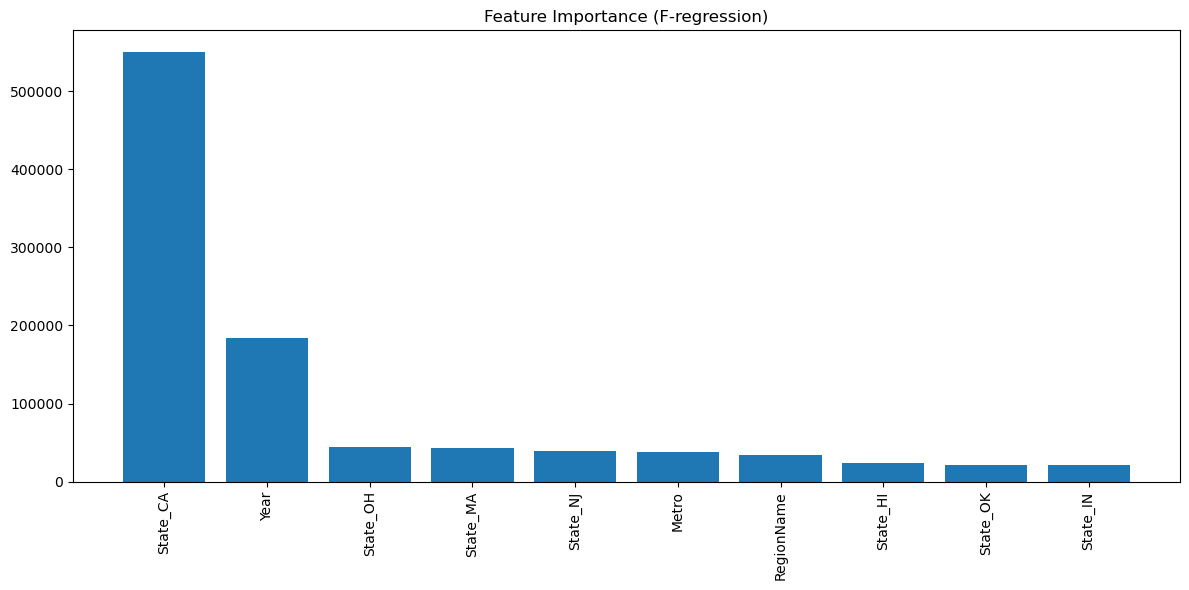

In [179]:
from sklearn.feature_selection import f_regression

# Feature Selection using F-regression for regression (faster than mutual information as the dataset is large)
selector = SelectKBest(score_func=f_regression, k=10)  # Select top 10 features
X_zl_train_selected = selector.fit_transform(X_zl_train_processed, y_zl_train)
X_zl_test_selected = selector.transform(X_zl_test_processed)

# Print selected feature names
selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

# Get f-regression scores
scores = selector.scores_
# Sort the scores of selected features only
indices = np.argsort(scores[selector.get_support()])[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importance (F-regression)")
plt.bar(range(len(selected_features)), scores[selector.get_support()][indices])
plt.xticks(range(len(selected_features)), [selected_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Since this dataset is so large, let's try using pca finding the components for .95, and only compare it with using the 10 selected features on random forest.

In [182]:
# Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit PCA to find components for 95% explained variance
pca = PCA(n_components=0.95)
X_zl_train_pca = pca.fit_transform(X_zl_train_selected)
X_zl_test_pca = pca.transform(X_zl_test_selected)

print("Number of PCA components for 95% variance:", pca.n_components_)

Number of PCA components for 95% variance: 1


In [184]:
# Evaluate model with all selected features
rf.fit(X_zl_train_selected, y_zl_train)
predictions_selected = rf.predict(X_zl_test_selected)
r2_selected = r2_score(y_zl_test, predictions_selected)
mse_selected = mean_squared_error(y_zl_test, predictions_selected)

print(f"Random Forest with 10 selected features:")
print(f"R2 Score: {r2_selected:.4f}")
print(f"Mean Squared Error: {mse_selected:.4f}")

# Evaluate model with PCA reduced features
rf.fit(X_zl_train_pca, y_zl_train)
predictions_pca = rf.predict(X_zl_test_pca)
r2_pca = r2_score(y_zl_test, predictions_pca)
mse_pca = mean_squared_error(y_zl_test, predictions_pca)

print(f"\nRandom Forest with PCA (95% variance):")
print(f"R2 Score: {r2_pca:.4f}")
print(f"Mean Squared Error: {mse_pca:.4f}")

Random Forest with 10 selected features:
R2 Score: 0.9977
Mean Squared Error: 120661575.4187

Random Forest with PCA (95% variance):
R2 Score: 0.8065
Mean Squared Error: 10157417403.4774


**Model Process Summary**

Performance Comparison:
- Random Forest with 10 Selected Features:
R2 Score: 0.9977 
Mean Squared Error: 120,661,575.4187
Interpretation: This model explains nearly all the variance in the dataset with a very high R2 score. The MSE translates to a root mean squared error (RMSE) of about 10,984.60 (sqrt(120,661,575.4187)), which indicates that, on average, predictions are off by about 10,984.60. Given the context of housing prices, this error is relatively low, suggesting decent model performance.

- Random Forest with PCA (95% Variance):
R2 Score: 0.8065
Mean Squared Error: 10,157,417,403.4774
Interpretation: With PCA reducing dimensions to just one component to capture 95% of the variance, the R2 score drops significantly to 0.8065. This indicates less variance is explained, which could be due to the loss of information or complexity when reducing to one dimension. The MSE here is much higher, leading to an RMSE of around 100,783.75 (sqrt(10,157,417,403.4774)), which is considerably larger than with the full feature set, showing that the predictions are much less accurate when using PCA in this manner.

Summary:
Model Without PCA (10 Selected Features) performs much better than the PCA, capturing nearly all variance in the data with a very small prediction error relative to housing valuations. This suggests that the selected features are highly informative for predicting housing prices.
Model With PCA explains 95% of the variance with just one component but at the cost of prediction accuracy. The significant drop in R2 and the increase in MSE indicate that reducing to one dimension has led to a considerable loss in predictive power. This might imply that the relationships between features and housing prices are complex or that important nuances are lost in this drastic dimensionality reduction.

Given these results, retaining the 10 selected features without applying PCA would be recommended for this task, as it provides a much more accurate model. However, if computational efficiency or interpretability is a priority, further investigation into PCA with perhaps more components or alternative dimensionality reduction techniques might be needed.